In [112]:
"""
These were (shamelessly) taken from cs231n course github code.
I believe these were coded by Andrej Karpathy so credit goes to him
for coding these.
"""

import numpy as np
import matplotlib.pyplot as plt


def create_dataset(N, D=2, K=2):
    X = np.zeros((N * K, D))  # data matrix (each row = single example)
    y = np.zeros(N * K)  # class labels

    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = np.linspace(0.0, 1, N)  # radius
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j

    # lets visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.show()

    y[y == 0] -= 1

    return X, y

def create_dataset_linear_two_labels(N, D=2, K=2):
    X = np.zeros((N * K, D))  # data matrix (each row = single example)
    y = np.zeros(N * K)  # class labels

    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = 10 + np.random.randn(N) * 4 # radius
        t = np.random.randn(N) * 0.2  # theta
        if(j == 0):
            h = -1
        else:
            h = 1
                
        X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]*h
        y[ix] = j

    # lets visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.show()

    y[y == 0] -= 1

    return X, y

def create_dataset_circle(N, D=2, K=5):
    X = np.zeros((N * K, D))  # data matrix (each row = single example)
    y = np.zeros(N * K)  # class labels

    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = 10 + np.random.randn(N) * 2 # radius
        t = (2*np.pi / K ) * (j+1) + np.random.randn(N) * 0.2 # theta
                
        X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
        y[ix] = j

    # lets visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.show()

    y[y == 0] -= 1
    #y[y != -1] = 1 Binary class, otherwise, the dataset has k classes

    return X, y

def create_dataset_islands_two_labels(N, D=2, K=2):
    X = np.zeros((N * K, D))  # data matrix (each row = single example)
    y = np.zeros(N * K)  # class labels

    for j in range(K):
        ix = range(N * j, N * (j + 1))
        t = np.linspace(0, 2*np.pi, N) + np.random.randn(N) * 0.2 
        if(j == 0):
            r = 10 + np.random.randn(N) * 0.5 # radius
        else:
            r = 4 + np.random.randn(N) * 0.5 # radius
                
        X[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
        y[ix] = j

    # lets visualize the data:
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.show()

    y[y == 0] -= 1

    return X, y



def plot_contour(X, y, svm):
    # plot the resulting classifier
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    points = np.c_[xx.ravel(), yy.ravel()]

    Z = svm.predict(points)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

    # plt the points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()

In [117]:
import numpy as np
import cvxopt

def linear(x, z):
    return np.dot(x, z.T)

def polynomial(x, z, p=4):
    return (1 + np.dot(x, z.T)) ** p

def gaussian(x, z, sigma=5):
    return np.exp(-np.linalg.norm(x - z, axis=1) ** 2 / (2 * (sigma ** 2)))

def sigmoid(x, z, kappa=1, c=-1):
    return np.tanh(kappa * np.dot(x, z.T) + c)

class SVM:
    def __init__(self, kernel=gaussian, C=1):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        self.y = y
        self.X = X
        m, n = X.shape

        # Calculate Kernel
        self.K = np.zeros((m, m))
        for i in range(m):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)
            
        # Solve with cvxopt final QP needs to be reformulated
        # to match the input form for cvxopt.solvers.qp
        P = cvxopt.matrix(np.outer(y, y) * self.K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options["show_progress"] = True
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol["x"])

    def predict(self, X):
        y_predict = np.zeros((X.shape[0]))
        sv = self.get_parameters(self.alphas)

        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                * self.y[sv, np.newaxis]
                * self.kernel(X[i], self.X[sv])[:, np.newaxis]
            )

        return np.sign(y_predict + self.b)

    def get_parameters(self, alphas):
        threshold = 1e-5

        sv = ((alphas > threshold) * (alphas < self.C)).flatten()
        self.w = np.dot(X[sv].T, alphas[sv] * self.y[sv, np.newaxis])
        self.b = np.mean(
            self.y[sv, np.newaxis]
            - self.alphas[sv] * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis]
        )
        return sv

# Assigment to send by the 1st of March

How to extend SVM to classify a sample x among k categories?

# One vs. the rest. 

For k classes, k binary classifiers are trained. Each determines whether an example belongs to its 'own' class versus any other class. The classifier with the largest output (y_predict in the code) is taken to be the class of the example.

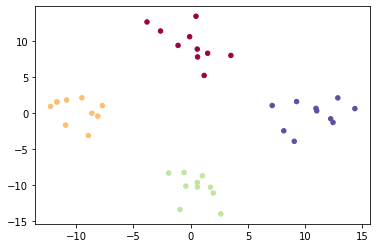

     pcost       dcost       gap    pres   dres
 0: -1.8037e+00 -4.9176e+01  5e+01  2e-15  7e-16
 1: -2.3721e+00 -5.0340e+00  3e+00  3e-16  4e-16
 2: -2.7851e+00 -3.2998e+00  5e-01  1e-16  2e-16
 3: -2.8888e+00 -2.9985e+00  1e-01  1e-15  1e-16
 4: -2.9121e+00 -2.9436e+00  3e-02  2e-16  2e-16
 5: -2.9220e+00 -2.9245e+00  3e-03  3e-16  1e-16
 6: -2.9229e+00 -2.9229e+00  6e-05  2e-16  1e-16
 7: -2.9229e+00 -2.9229e+00  1e-06  8e-16  1e-16
Optimal solution found.


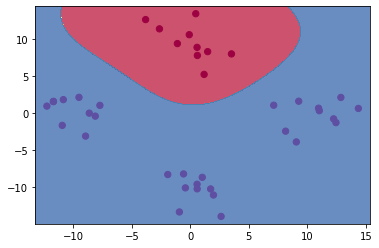

Accuracy: 1.0
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]


In [120]:
np.random.seed(1)
X, y = create_dataset_circle(N=10, K=4)

svm = SVM(kernel=gaussian)
svm.fit(X, y) # Train
y_pred = svm.predict(X) # Predict
plot_contour(X, y, svm)

print(f"Accuracy: {sum(y==y_pred)/y.shape[0]}")

print(y)
print(y_pred)

In [104]:
print(X)
print(y)

[[ -3.81922466  12.68626537]
 [  3.51470716   8.04198736]
 [  0.57631815   8.92506857]
 [  0.60268436   7.83090501]
 [ -2.63727142  11.43052169]
 [  1.17765385   5.26686862]
 [  0.46510612  13.48160299]
 [  1.48078898   8.34725894]
 [ -0.08981356  10.63769905]
 [ -1.10498948   9.43678576]
 [ -7.72426285   1.07538208]
 [-12.25077725   0.97415327]
 [-11.69188605   1.61706299]
 [-10.84812949   1.85144872]
 [-11.69552126   1.57961583]
 [ -8.63251659   0.02186552]
 [ -9.51169138   2.16160268]
 [ -8.11952947  -0.38094819]
 [ -8.94752701  -3.08436272]
 [-10.93912726  -1.63548808]
 [  0.57696059  -9.59900505]
 [ -0.57895364  -8.20434   ]
 [ -1.92671007  -8.28459043]
 [ -0.93442344 -13.35225251]
 [ -0.42191108 -10.09280075]
 [  1.02142871  -8.6660205 ]
 [  1.73387358 -10.23601957]
 [  2.6291675  -13.95499804]
 [  0.58458302 -10.22361841]
 [  1.97843548 -11.05882797]
 [  8.13949713  -2.41849826]
 [ 12.44213964  -1.25960386]
 [ 11.02021227   0.352849  ]
 [  9.25980251   1.63944544]
 [ 10.95517172